# MLiA Ch. 6: support vector machines

## SVM classifier 목적 함수 수식화 

원래의 문제는 classifier($\mathbf{w}$, $b$)가 만드는 hyperplane과 support vector 간 margin($\frac{2}{\lVert\mathbf{w}\rVert}$)을 N개의 선형 부등식(N개의 training data는 hyperplane과의 거리 모두 1 이상)의 제약 아래에서 최대화하는 문제

> $ \underset{\mathbf{w}}{\operatorname{arg\,max}}\,\frac{2}{\lVert\mathbf{w}\rVert}$
>
> subject to $t_i(\mathbf{w}^T\mathbf{x}_i+b)\geq 1$ for $i=1,\dots,N $

Convex function의 최소화 문제로 풀 수 있도록 목적 함수 변형

> $ \underset{\mathbf{w}}{\operatorname{arg\,min}}\,J(\mathbf{w})=\frac{1}{2}{\lVert\mathbf{w}\rVert}^2$
>
> subject to $ t_i(\mathbf{w}^T\mathbf{x}_i+b)\geq 1$ for $i=1,\dots,N $

불완전한 분리 상황도 해결할 수 있도록 slack variable($\xi$) 허용하고 사용자 지정 regularization parameter($C$)로 비중을 조절하는 문제로 확장

> $ \underset{\mathbf{w}}{\operatorname{arg\,min}}\,J(\mathbf{w,\xi})=\frac{1}{2}{\lVert\mathbf{w}\rVert}^2+C\sum^N_{i=1}\xi_i $
>
> subject to $ t_i(\mathbf{w}^T\mathbf{x}_i+b)\geq 1-\xi$ for $i=1,\dots,N $

목적 함수와 제약 조건들을 합쳐 Lagrangian 함수를 만들고, KKT(Karush-Kuhn-Tucker) 조건, convex optimization 문제에 대한 Wolfe dual 표현 적용하여 등식 조건 아래 다음을 최대화하는 $\alpha_i$(Lagrange multiplier)를 구하는 문제로 변형(비선형 분류 시 kernel trick 적용 위해)

> $ \underset{\mathbf{\alpha}}{\operatorname{arg\,max}}\,\tilde{L}(\mathbf{\alpha})=\sum^N_{i=1}\alpha_i - \frac{1}{2}\sum^N_{i=1}\sum^N_{j=1} \alpha_i\alpha_j t_i t_j \mathbf{x}_i^T \mathbf{x}_j$
>
> subject to $ \sum^N_{i=1}\alpha_i t_i=0 $ and $ 0\leq\alpha_i\leq C$ for $i=1, \dots , N $

- 참고
  - 오일석, "패턴인식," 교보문고, 2008
  - 한학용, "패턴인식 개론," 한빛미디어, 2009
  - Support Vector Machine Tutorial, http://www.slideshare.net/JungkyuLee1/svm-4rd-edition
  - C. Burges, "A tutorial on support vector machines for pattern recognition," Data Mining and Knowledge Discovery, 1998
  - S. Theodoridis and K. Koutroumbas, "Pattern Recognition," Elsevier, 2009

## SMO 알고리즘 이용한 SVM 학습 

여러 가지 변환을 통해 학습을 좀더 쉬운 문제로 바꾸었으나 수많은 2차 항(약 $\frac{N^2}{2}$개)이 포함된 quadratic programming 문제로 여전히 풀기 어려우며 SMO, cutting-plane 등의 알고리즘들을 이용하여 수치적으로 최적 classifier를 탐색 

- SMO(Sequential Minimal Optimization): 1996년 John Platt이 발표한 SVM 학습 알고리즘으로 한 번에 $\sum^N_{i=1}\alpha_i t_i=0 $ 제약 만족할 수 있는 최소 변경 단위인 두 개의 $\alpha$ 값만 변수로 정하고 나머지 $\alpha$ 값들은 고정한 상태에서 최적화를 수행한 후 $\alpha$의 쌍을 바꾸어가며 단계적으로 SVM 최적화 문제를 풀어 나감

> Repeat till convergence {
>
> 1. Select some pair $\alpha_i$ and $\alpha_j$ to update next (using a heuristic that tries to pick the two that will allow us to make the biggest progress towards the global maximum).
>
> 2. Reoptimize $\tilde{L}(\alpha)$ with respect to $\alpha_i$ and $\alpha_j$, while holding all the other $\alpha_k$’s ($k \neq i, j$) fixed.
>
> }

- 참고
  - J. Platt, "Sequetial minimal optimization: A fast algorithm for training support vector machines," Technical Report MST-TR-98-14, Microsoft Research,1998
  - J. Platt, "Fast Training of Support Vector Machines Using Sequential Minimal Optimization," Advances in Kernel Methods - Support Vector Learning, 1998
  - ___, "Sequential Minimal Optimization for SVM," ftp://www.ai.mit.edu/pub/users/tlp/projects/svm/svm-smo/smo.pdf
  - Andrew Ng, "The Simplified SMO Algorithm," Lecture Notes for Stanford CS229 in Autumn 2009. http://cs229.stanford.edu/materials/smo.pdf

### Helper functions

Training data loading, random number generation, clipping

In [2]:
from numpy import *
from time import sleep

def loadDataSet(fileName):
    dataMat = []; labelMat = []
    fr = open(fileName)
    for line in fr.readlines():
        lineArr = line.strip().split('\t')
        dataMat.append([float(lineArr[0]), float(lineArr[1])])
        labelMat.append(float(lineArr[2]))
    return dataMat,labelMat

def selectJrand(i,m):
    j=i #we want to select any J not equal to i
    while (j==i):
        j = int(random.uniform(0,m))
    return j

def clipAlpha(aj,H,L):
    if aj > H: 
        aj = H
    if L > aj:
        aj = L
    return aj

In [3]:
dataArr,labelArr = loadDataSet('testSet.txt')

In [7]:
shape(dataArr),shape(labelArr)

((100, 2), (100,))

### Simplified SMO

(실행 시간 측면) 최적의 첫 번째 $\alpha$를 선택하는 절차를 생략하고 모든 $\alpha$를 첫 번째 최적화 대상으로 선정하여 최적화하는 version부터 시작

- Matrix 연산
    - multiply(x, y): matrix x와 y의 element-wise multiplication
    - x*y: matrix x와 y의 matrix multiplication
- SVM classifier 적용 code    
    ```python
    fXi = float(multiply(alphas,labelMat).T*(dataMatrix*dataMatrix[i,:].T)) + b
    ```
    - $ d(\mathbf{x})=\sum_{\mathbf{x}_k\in Y}\alpha_k t_k \mathbf{x}_k^T \mathbf{x} + b=\sum_{\mathbf{x}_k\in Y}\alpha_k t_k (\mathbf{x}_k \cdot \mathbf{x}) + b$ 
    
    ($d(\mathbf{x})\gt 0$이면 $\mathbf{x}\in \omega_1$, $d(\mathbf{x})\lt 0$이면 $\mathbf{x}\in \omega_2$)
- KKT 조건 위반 여부 판별 code
    ```python
    if ((labelMat[i]*Ei < -toler) and (alphas[i] < C)) or ((labelMat[i]*Ei > toler) and (alphas[i] > 0)):
    ```
    - 참고
        - '1.5. The KKT conditions' in 'Sequential Minimal Optimization for SVM'(ftp://www.ai.mit.edu/pub/users/tlp/projects/svm/svm-smo/smo.pdf) 내
        - Eq. (12) in 'Sequetial minimal optimization: A fast algorithm for training support vector machines'

In [16]:
def smoSimple(dataMatIn, classLabels, C, toler, maxIter):
    dataMatrix = mat(dataMatIn); labelMat = mat(classLabels).transpose()
    b = 0; m,n = shape(dataMatrix)    # m: training data vector 개수, n: training data vector의 차원 수(feature 개수)
    alphas = mat(zeros((m,1)))
    iter = 0
    while (iter < maxIter):
        alphaPairsChanged = 0
        # Training data vector set에 대해 순차 수행
        for i in range(m):          
            # fxi = i번째 data vector에 대한 현재까지 훈련된 classifier 함수 적용 결과
            # NOTE: multiply(): element-wise multiplication (NOT matrix multiplication), '*': matrix multiplication
            fXi = float(multiply(alphas,labelMat).T*(dataMatrix*dataMatrix[i,:].T)) + b   
            # Ei = i번째 data vector에 대한 error(예측치-정답)
            Ei = fXi - float(labelMat[i])#if checks if an example violates KKT conditions
            # KKT condition을 위반하는 경우 최적화를 계속 진행함('toler' 값에 해당하는 tolerance는 허용)
            if ((labelMat[i]*Ei < -toler) and (alphas[i] < C)) or ((labelMat[i]*Ei > toler) and (alphas[i] > 0)):
                # alpha_i와 함께 최적화 대상 pair가 될 alpha_j를 random하게 선택
                j = selectJrand(i,m)
                # fxj = j번째 data vector에 대한 현재까지 훈련된 classifier 함수 적용 결과
                fXj = float(multiply(alphas,labelMat).T*(dataMatrix*dataMatrix[j,:].T)) + b
                # Ej = j번째 data vector에 대한 error(예측치-정답)
                Ej = fXj - float(labelMat[j])
                # 새로운 alpha 값에 의해 update되기 전에 현재 값 backup
                alphaIold = alphas[i].copy(); alphaJold = alphas[j].copy();
                # alpha에 대한 두 가지 제약을 만족하는 새로운 alpha_j의 변경 가능 범위 설정(L<=alpha_j<H)
                # (i, j 제외 나머지 alpha는 모두 상수로 간주되므로 선형 등식 제약 조건에 의해 alpha_j 결정되면 alpha_i도 함께 결정됨
                #  Training data i와 j의 label이 다른 경우 alpha_i - alpha_j = constant
                #  Training data i와 j의 label이 같은 경우 alpha_i + alpha_j = constant)
                if (labelMat[i] != labelMat[j]):
                    L = max(0, alphas[j] - alphas[i])
                    H = min(C, C + alphas[j] - alphas[i])
                else:
                    L = max(0, alphas[j] + alphas[i] - C)
                    H = min(C, alphas[j] + alphas[i])
                # alpha가 더 움직일 여지가 없음. 다음 data sample로 넘어감.
                if L==H: print "L==H"; continue
                # eta = 목적 함수의 이차 미분값(alpha_i와 alpha_j의 선형 조합이 constant 조건 아래에서(즉 나머지 alpha는 constant))
                eta = 2.0 * dataMatrix[i,:]*dataMatrix[j,:].T - dataMatrix[i,:]*dataMatrix[i,:].T - dataMatrix[j,:]*dataMatrix[j,:].T
                # eta가 0 이상이면 비정상적 상황(잘못된 classification?) => 다음 단계로 skip
                # (정상 분류 상황이라면 목적 함수는 alpha_j(또는 alpha_i)의 concave function)
                if eta >= 0: print "eta>=0"; continue
                # eta가 음수이면 정상 상황
                # eta와 현재 error 값(Ei, Ej)을 가지고 목적 함수의 최대값 방향으로 이동하는 새로운 alpha_j 값을 결정함
                alphas[j] -= labelMat[j]*(Ei - Ej)/eta
                alphas[j] = clipAlpha(alphas[j],H,L)
                # alpha 값의 증감분이 특정 수준 이하인 경우 더 이상 최적화 진행하지 않고 다음 단계로 skip(최적화 완료?)
                if (abs(alphas[j] - alphaJold) < 0.00001): print "j not moving enough"; continue
                # 새롭게 결정된 alpha_j 값으로부터 새로운 alpha_i 값 도출
                alphas[i] += labelMat[j]*labelMat[i]*(alphaJold - alphas[j])#update i by the same amount as j
                                                                        #the update is in the oppostie direction
                # 새로운 b 값의 결정
                b1 = b - Ei- labelMat[i]*(alphas[i]-alphaIold)*dataMatrix[i,:]*dataMatrix[i,:].T - labelMat[j]*(alphas[j]-alphaJold)*dataMatrix[i,:]*dataMatrix[j,:].T
                b2 = b - Ej- labelMat[i]*(alphas[i]-alphaIold)*dataMatrix[i,:]*dataMatrix[j,:].T - labelMat[j]*(alphas[j]-alphaJold)*dataMatrix[j,:]*dataMatrix[j,:].T
                if (0 < alphas[i]) and (C > alphas[i]): b = b1
                elif (0 < alphas[j]) and (C > alphas[j]): b = b2
                else: b = (b1 + b2)/2.0
                #여기까지 continue 없이 진행되면 alpha에 대한 update가 진행되었음을 mark
                alphaPairsChanged += 1
                print "iter: %d i:%d, pairs changed %d" % (iter,i,alphaPairsChanged)
        # 이전 단계의 for loop에서 alpha 쌍에 대한 update가 전혀 없었던 경우 1회의 iteration이 완료된 것으로 간주
        if (alphaPairsChanged == 0): iter += 1
        else: iter = 0
        print "iteration number: %d" % iter
    return b,alphas

In [10]:
b,alphas = smoSimple(dataArr, labelArr, 0.6, 0.001, 40)

L==H
L==H
L==H
iter: 0 i:3, pairs changed 1
iter: 0 i:4, pairs changed 2
L==H
iter: 0 i:7, pairs changed 3
L==H
iter: 0 i:10, pairs changed 4
iter: 0 i:17, pairs changed 5
L==H
L==H
j not moving enough
j not moving enough
j not moving enough
j not moving enough
iter: 0 i:54, pairs changed 6
L==H
iter: 0 i:83, pairs changed 7
iteration number: 0
j not moving enough
j not moving enough
j not moving enough
L==H
j not moving enough
j not moving enough
L==H
j not moving enough
L==H
j not moving enough
j not moving enough
j not moving enough
L==H
L==H
L==H
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
L==H
j not moving enough
L==H
j not moving enough
j not moving enough
iteration number: 1
j not moving enough
iter: 1 i:3, pairs changed 1
j not moving enough
iter: 1 i:7, pairs changed 2
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
iter: 1 i:29, pairs changed 3
iter:

In [12]:
alphas[alphas>0],b

(matrix([[ 0.1498973 ,  0.112352  ,  0.0889268 ,  0.00900463,  0.34217147]]),
 matrix([[-3.73150655]]))

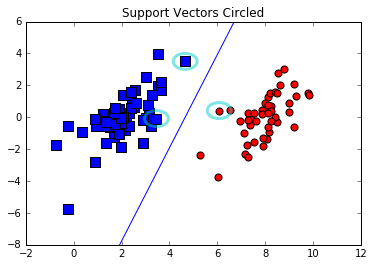

<module 'plotSupportVectors' from 'plotSupportVectors.pyc'>

In [15]:
%matplotlib inline
import plotSupportVectors
reload(plotSupportVectors)

### Full SMO

비선형의 classification일 필요한 경우 mapping 함수($\Phi(\mathbf{x})$)를 이용하여 선형 분리가 가능한 더 높은 차원으로 확장하여 해결 가능하며, Wolfe dual form에서는 항상 mapping 함수의 내적($K(\mathbf{x}_i, \mathbf{x}_j)$)으로 나타나므로 mapping 함수의 차원이 높아지더라도 계산 복잡도가 높아지지 않음(Kernel trick)

> $ \underset{\mathbf{\alpha}}{\operatorname{arg\,max}}\,\tilde{L}(\mathbf{\alpha})=\sum^N_{i=1}\alpha_i - \frac{1}{2}\sum^N_{i=1}\sum^N_{j=1} \alpha_i\alpha_j t_i t_j K(\mathbf{x}_i, \mathbf{x}_j) $
>
> where $K(\mathbf{x}_i, \mathbf{x}_j)=\Phi(\mathbf{x}_i)\cdot\Phi(\mathbf{x}_j)$
>
> subject to $ \sum^N_{i=1}\alpha_i t_i=0 $ and $ 0\leq\alpha_i\leq C, i=1, \dots , N $